## TODO
1. n*thre -> n*std DONE
2. visualization, result table
3. report


In [23]:
count = 0
count_neg_ret = 0
for table in test_list:
    table['cum_ret'] = table['daily_ret'].cumsum()

    if table['nav_cumprod'].iloc[-1] < 1:
        count += 1
    if (table['nav_cumprod'] < 0).any():
        count_neg_ret += 1
print(count)

# 爆仓
print(count_neg_ret)

33
2


# results visualization

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


with open('output_MRP/test_tables_train8_test2.pkl', 'rb') as file:
    test_list = pickle.load(file)

with open('output_MRP/train_tables_train8_test2.pkl', 'rb') as file:
    train_list = pickle.load(file)

## preprocesisng, get nav columns

def generate_nav_columns(table):
    table['nav_cumprod'] = (table['daily_ret'] + 1).cumprod()
    table['nav_cumsum'] = (table['daily_ret']).cumsum() + 1
    return table

for idx in range(len(test_list)):
    test_list[idx] = generate_nav_columns(test_list[idx])
    train_list[idx] = generate_nav_columns(train_list[idx])


In [29]:
test_list[0].head()

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,daily_ret,nav_cumprod,nav_cumsum,cum_ret
date,,,,,,,,,,
1990-08-29,41.286370,-0.448980,0.371677,1,0,1.0,0.000000,1.000000,1.000000,0.000000
1990-08-30,40.722353,-1.012997,0.371677,1,0,1.0,-0.142605,0.857395,0.857395,-0.142605
1990-08-31,41.186126,-0.549224,0.371677,1,0,1.0,0.117259,0.957933,0.974654,-0.025346
1990-09-04,40.800934,-0.934416,0.371677,1,0,1.0,-0.097391,0.864639,0.877264,-0.122736
1990-09-05,40.641073,-1.094277,0.371677,1,0,1.0,-0.040419,0.829691,0.836844,-0.163156


## Part I: statistics report

In [ ]:
tabel = test_list[0]



In [ ]:
def trade_table_statistics(table):

    # # calculate the daily return
    # table['ret'] = table['cum_ret'] / table['cum_ret'].shift(1) - 1

    # 1. calcualte number of openings/closings achieved during the period
    prev_pos = table['position'].shift(1)
    prev_pos.iloc[0] = 0
    mask = (table['position'] == 0)
    num_closings = np.sum(np.abs(prev_pos[mask]))

    mask = (prev_pos == 0)
    num_openings = np.sum(np.abs(table['position'][mask]))


    # 2. cum return over the period
    final_cum_ret = table['cum_ret'].iloc[-1]

    # 3. start_date and end_date
    start_date = table.index[0]
    end_date = table.index[-1]

    # 4. max_drawdown
    # cum_ret = table['cum_ret']

    # def calculate_max_drawdown(value_series):
    #     curr_max = value_series.iloc[0]
    #     max_drawdown = 0

    #     for val in value_series:
    #         if val > curr_max:
    #             curr_max = val

    #         drawdown = val / curr_max - 1
    #         if drawdown < max_drawdown:
    #             max_drawdown = drawdown


    #     return max_drawdown

    # max_drawdown = calculate_max_drawdown(cum_ret)

    # 5. nav percentile
    # cum_ret = table['cum_ret']
    # nav_min = np.min(cum_ret)
    # nav_max = np.max(cum_ret)
    # nav_median = np.median(cum_ret)
    # nav_25 = np.percentile(cum_ret, 25)
    # nav_75 = np.percentile(cum_ret, 75)

    # 6. sharpe ratio (daily basis)
    daily_ret = table['ret'].iloc[1:] # first ret is NaN
    sharpe_daily = np.mean(daily_ret) / np.std(daily_ret)

    # 7. geometric averate daily ret
    # cum_ret = table['cum_ret'].iloc[-1]
    # num_periods = len(table) - 1
    # average_daily_ret = cum_ret ** (1/num_periods) - 1 

    # 8. average holding period
    def calculate_holding_periods(position_series):
        total_holding_days = 0
        total_num_opens = 0
        curr_open = False

        for position in position_series:
            if not curr_open:
                if position != 0:
                    curr_open = True
                    total_num_opens += 1
            else:
                total_holding_days += 1
                if position == 0:
                    curr_open = False
        average_holding_period = total_holding_days / total_num_opens

        return average_holding_period
    position_series = table['position']
    average_holding_period = calculate_holding_periods(position_series)

    stats = {
        'start_date': start_date,
        'end_date': end_date,

        'sharpe_daily': sharpe_daily,
        'cum_return': final_cum_ret,
        # 'max_drawdown': max_drawdown,
        # 'average_daily_ret': average_daily_ret,

        # 'nav_min': nav_min,
        # 'nav_25': nav_25,
        # 'nav_median': nav_median,
        # 'nav_75': nav_75,
        # 'nav_max': nav_max,

        'num_openings': num_openings,
        'num_closings': num_closings,
        'average_holding_period': average_holding_period,
    }
    
    return stats


def create_stats_summary(table_list):
    summary_df = pd.DataFrame()
    
    for table in table_list:

        stats = trade_table_statistics(table)
        stats_df = pd.DataFrame([stats])
        summary_df = pd.concat([summary_df, stats_df], ignore_index=True)
    
    return summary_df

# stats_df = create_stats_summary(test_list)
stats_df = create_stats_summary(test_list)
stats_df.head()


,start_date,end_date,sharpe_daily,cum_return,num_openings,num_closings,average_holding_period
0,1990-08-29,1990-10-26,NaN,-0.327694,1.0,0.0,41.000000
1,1990-10-26,1990-12-26,NaN,1.340214,5.0,4.0,6.600000
2,1990-12-26,1991-02-25,NaN,-0.089603,3.0,2.0,11.333333
3,1991-02-25,1991-04-24,NaN,3.878579,9.0,8.0,3.111111
4,1991-04-24,1991-06-21,NaN,1.138287,3.0,2.0,12.666667


In [77]:
stats_df.describe()

,start_date,end_date,sharpe_daily,cum_return,num_openings,num_closings,average_holding_period
count,82,82,0.0,82.000000,82.000000,82.000000,82.000000
mean,1997-03-26 12:52:40.975609728,1997-05-24 22:14:38.048780544,NaN,0.942768,3.231707,2.268293,18.116686
min,1990-08-29 00:00:00,1990-10-26 00:00:00,NaN,-4.123274,1.000000,0.000000,2.625000
25%,1993-12-09 06:00:00,1994-02-07 12:00:00,NaN,-0.105560,1.250000,1.000000,6.750000
50%,1997-03-25 00:00:00,1997-05-22 00:00:00,NaN,0.633232,3.000000,2.000000,12.333333
75%,2000-07-08 18:00:00,2000-09-05 12:00:00,NaN,1.671760,4.000000,3.750000,32.750000
max,2003-10-29 00:00:00,2003-12-29 00:00:00,NaN,8.469398,9.000000,8.000000,41.000000
std,NaN,NaN,NaN,1.653534,1.970766,1.962920,13.896184


In [54]:
table = test_list[0]

table

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret,daily_ret,ret
date,,,,,,,,,
1990-08-29,41.286370,-0.448980,0.371677,1,0,1.0,1.000000,0.000000,NaN
1990-08-30,40.722353,-1.012997,0.371677,1,0,1.0,0.848251,-0.151749,-0.151749
1990-08-31,41.186126,-0.549224,0.371677,1,0,1.0,0.954094,0.124779,0.124779
1990-09-04,40.800934,-0.934416,0.371677,1,0,1.0,0.855215,-0.103636,-0.103636
1990-09-05,40.641073,-1.094277,0.371677,1,0,1.0,0.818432,-0.043011,-0.043011
1990-09-06,40.504824,-1.230526,0.371677,1,0,1.0,0.788430,-0.036658,-0.036658
1990-09-07,40.968138,-0.767212,0.371677,1,0,1.0,0.886712,0.124655,0.124655
1990-09-10,39.533538,-2.201812,0.371677,1,0,1.0,0.544458,-0.385980,-0.385980
1990-09-11,40.336644,-1.398706,0.371677,1,0,1.0,0.662103,0.216076,0.216076


In [56]:
(table['daily_ret'] +1).cumprod()

date
1990-08-29    1.000000
1990-08-30    0.848251
1990-08-31    0.954094
1990-09-04    0.855215
1990-09-05    0.818432
1990-09-06    0.788430
1990-09-07    0.886712
1990-09-10    0.544458
1990-09-11    0.662103
1990-09-12    0.736361
1990-09-13    0.723160
1990-09-14    0.712002
1990-09-17    0.869432
1990-09-18    0.889971
1990-09-19    0.822681
1990-09-20    0.470671
1990-09-21    0.596581
1990-09-24    0.710550
1990-09-25    0.493482
1990-09-26    0.526606
1990-09-27    0.499857
1990-09-28    0.597281
1990-10-01    0.671310
1990-10-02    0.677815
1990-10-03    0.541392
1990-10-04    0.575421
1990-10-05    0.405513
1990-10-08    0.476245
1990-10-09    0.390723
1990-10-10    0.448324
1990-10-11    0.355512
1990-10-12    0.283680
1990-10-15    0.411885
1990-10-16    0.377846
1990-10-17    0.327927
1990-10-18    0.315444
1990-10-19    0.313287
1990-10-22    0.223343
1990-10-23    0.234814
1990-10-24    0.295869
1990-10-25    0.294239
1990-10-26    0.323462
Name: daily_ret, dtype: float

In [29]:
np.argmax(stats_df['cum_return'])

27

In [36]:
test_list_filtered[5]

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret,ret
date,,,,,,,,
1991-06-21,20.251160,-0.018547,0.460676,0,0,0.0,1.000000,NaN
1991-06-24,20.532713,0.263006,0.460676,0,1,0.0,1.000000,0.000000
1991-06-25,20.255546,-0.014161,0.460676,0,1,0.0,1.000000,0.000000
1991-06-26,20.366146,0.096439,0.460676,0,1,0.0,1.000000,0.000000
1991-06-27,19.928190,-0.341517,0.460676,0,1,0.0,1.000000,0.000000
1991-06-28,18.757510,-1.512197,0.460676,1,0,1.0,1.000000,0.000000
1991-07-01,20.418042,0.148335,0.460676,0,1,0.0,1.088526,0.088526
1991-07-02,19.875684,-0.394023,0.460676,0,1,0.0,1.088526,0.000000
1991-07-03,19.626348,-0.643359,0.460676,1,0,1.0,1.088526,0.000000


## Part II: trading snapshot

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def visualize_trading_snapshot(trade_table):
    dates = trade_table.index

    start_date = dates[0]
    end_date = dates[-1]

    # Create figure with subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
    # fig.suptitle(f"Traing Snapshot, start={start_date.strftime('%Y-%m-%d')}, end={end_date.strftime('%Y-%m-%d')}", 
    #              fontsize=16)

    # Format x-axis dates
    date_format = mdates.DateFormatter('%Y-%m-%d')
    for ax in [ax1, ax2, ax3, ax4]:
        ax.xaxis.set_major_formatter(date_format)
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
        ax.grid(True, linestyle='--', alpha=0.7)

    # 1. Portfolio nav over time
    ax1.plot(dates, trade_table['nav_cumsum'], color='#8884d8', linewidth=2, label='nav_cumsum', alpha=0.7)
    ax1.plot(dates, trade_table['nav_cumprod'], linewidth=2, label='nav_cumprod', alpha=0.7)
    ax1.set_ylabel('nav')
    ax1.set_title("Portfolio Net Asset Value Over Time")
    ax1.legend()

    # 2. Holding position over time
    ax2.step(dates, trade_table['position'], color='#ff5722', linewidth=2, where='post')
    ax2.set_title('Holding Position Over Time')
    ax2.set_ylabel('position')
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(['Short', 'Closed', 'Long'])
    ax2.set_ylim(-1.5, 1.5)


    # 3. Stock prices over time
    ax3.plot(dates, trade_table['portfolio_value'], color='#ff7300', linewidth=2)
    ax3.set_ylabel('asset value')
    ax3.set_title('Underlying Asset Value Over Time')


    # 4. Improved residuals plot
    residuals = trade_table['residuals']
    thr = trade_table['threshold'].iloc[0]

    ax4.plot(dates, residuals, color='#1f77b4', linewidth=1.5)
    ax4.axhline(y=thr, color='#2ca02c', linestyle='--', linewidth=1.5, label=f'long threshold', alpha=0.5)
    ax4.axhline(y=-thr, color='#d62728', linestyle='--', linewidth=1.5, label=f'short threshold', alpha=0.5)

    ax4.set_title('OLS Residuals Over Time')
    ax4.set_ylabel('residuals')
    ax4.legend(loc='best')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    plt.show()

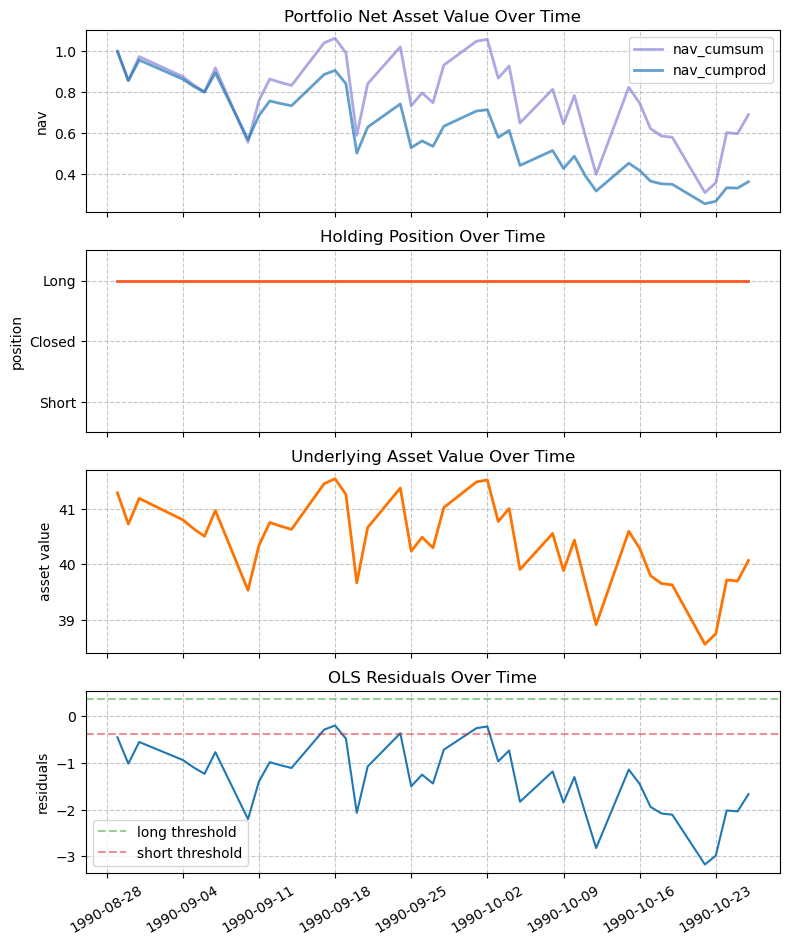

In [27]:
idx=0
table = test_list[idx]

visualize_trading_snapshot(table)